In [1]:
import os

import pandas as pd
import numpy as np
import string

from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.lines as mlines
import skill_metrics as sm

# 2.0 Set variables and functions

In [131]:
# Set inputs
MODELS = ['ShoreFor', 'Chronos','lag-llama'] # List of models
# List of mode types in Hybrid, Data-driven or ensemble
MODEL_TYPES = {'ShoreFor': 'Hybrid', 'Chronos':'LLM',
              'lag-llama':'LLM'} 
TRANSECTS = ['Transect2', 'Transect5', 'Transect8'] # List of transects for evaluation


fp_input = 'datasets/shorelines' # File path for input data
fp_sub = 'submissions/{}' # File path for submission

fn_obs = 'shorelines_obs.csv' # File name for observed shoreline
fn_targ = 'shorelines_target_shortterm.csv' # File name for target shoreline
fn_cali = 'shorelines_calibration.csv' # File name for calibration shoreline
fn_pred = 'shorelines_prediction.csv' # File name for calibration shoreline

In [132]:
def plot_ts(tran_ids, df_obs, dfs_cali=None, df_targ=None, dfs_pred=None, output_path=None):
    
    '''
    This function plot time series of observation, calibration, target and prediction
    
    Input: 
    tran_ids: id of target transects to plot
    df_obs: DataFrame for observation
    dfs_cali: DataFrames for calibration from different models
    df_target: DataFrame for target
    dfs_pred: DataFrames for prediction from different models
    output_path: Output path to save figure
    '''
    
    fig, axes = plt.subplots(len(tran_ids), 1, figsize=(8, 2.5*len(tran_ids)))
    cmap = get_cmap("Dark2")
    letters = string.ascii_lowercase # Letters used to label subplots
    
    for i, tran_id in enumerate(tran_ids):
        if len(tran_ids) == 1:
            ax = axes
        else:
            ax = axes[i]

        # Add subtitle
        ax.set_title(tran_id)
        # Add label
        ax.text(0.01,0.95, letters[i] + ') ', 
                    bbox=dict(boxstyle="square", ec='k',fc='w',alpha=0.5), 
                    ha='left',va='top', transform=ax.transAxes, zorder=10)
        
        # Plot observation
        ax.plot(df_obs.index, df_obs[tran_id], color='k', label='Obs', linestyle='-')

        if (dfs_cali is not None)&(dfs_pred is None):
            # Plot model calibration
            n_items = len(dfs_cali.keys())
            colors = cmap(np.arange(n_items)) # Colors used for models
            for j, model in enumerate(dfs_cali.keys()):
                ax.plot(dfs_cali[model].index, dfs_cali[model][tran_id], 
                        color=colors[j], label=model, linestyle='-')

        if df_targ is not None:
            # Plot target time series
            ax.plot(df_targ.index, df_targ[tran_id], color='k', 
                    linestyle=(0, (5, 1)), label='Targ')
            ax.set_xlim(df_targ.index.min()-(df_targ.index.max()-df_targ.index.min()), 
                        df_targ.index.max())
            

        if dfs_pred is not None:
            # Plot model calibration
            n_items = len(dfs_pred.keys())
            colors = cmap(np.arange(n_items)) # Colors used for models
            for j, model in enumerate(dfs_pred.keys()):
                ax.plot(dfs_pred[model].index, dfs_pred[model][tran_id], 
                        linestyle=(0, (5, 1)), color=colors[j], label=model)


        # Add legend and ylabel for first plot
        if i == 0: 
            ax.legend(ncol=(n_items+2)//5+1, bbox_to_anchor=[1.2,1],
                      edgecolor='k');
            ax.set_ylabel('Shoreline Position (m)')
            
        fig.subplots_adjust(hspace=0.3)

    
    if output_path is not None:
        fig.savefig(output_path, dpi=300, 
                    bbox_inches="tight", pad_inches=0.01)
        print('\nSaved plot to {}'.format(output_path))

    return fig

In [133]:
def cal_metrics(df_ref, df_model, norm=True):
    
    '''
    This function calculates std, corr and rmse
    
    Input:
    df_ref: DataFrame for reference (obs/target)
    df_model: DataFrame for model (calibration/prediction)
    norm: Apply normalization (default=True)
    
    Output:
    std: (Normalized) standard deviation
    corr: Correlation coefficient
    rmse: (Normalized) root mean sequare error
    score: Distance to target in the Taylor diagram
    '''
    
    # Extract the model result at time points fo reference
    df_ref = df_ref.loc[(~df_ref.isna()).any(1), :]
    df_model = df_model.reindex(df_ref.index, method='Nearest')
    #m_idx = df_model.index.intersection(df_ref.index)

    # Take average for transects
    ref = df_ref.to_numpy().transpose()
    model = df_model.to_numpy().transpose()
    
    std0 = np.nanstd(ref)
    std = np.nanstd(model)
    corr = np.corrcoef(model, ref)[0, 1]
    rmse = sm.centered_rms_dev(model,ref)
    
    if norm==True:
        std = std/std0
        rmse = std/std0
    
    dist = np.sqrt((1-std)**2+(1-corr)**2+(0-rmse)**2)
    
    return std, corr, rmse, dist
    

In [134]:
def plot_taylor(metrics, legend='Invidivual', aver_scores=None, ax=None):
    
    '''
    This function plots Taylor diagram based metrics
    
    Input:
    metrics (dict): Metrics to plot in the diagram   
        -Format of metrics:
        -metrics = {
            'Observation/Target': (std, corr, rmse)
            'Calibration/Prediction':{
            'model1': (std, corr, rmse),
            'model2': (std, corr, rmse),
                }
            }

    legend (string): The style of legend ('Individual'|'Average'|None)
        - None: No legend plotted
        -'Individual': Label each subplot based on the score for the individual transect
        -'Average': Label the first subplot with the average score (need to provide the average score)
    aver_scores (dict): The average score for each model
    ax: Ax used for plot    
    
    Output:
    ax: Ax with plot
    '''
    
    
    # Set variables for plot
    
    MARKERS = {
    'Hybrid': '*',
    'Data-Driven':'s',
    'LLM': '^'
    }

    # specify some styles for the correlation component
    COLS_COR = {
        'grid': '#DDDDDD',
        'tick_labels': '#000000',
        'title': '#000000'
    }

    # specify some styles for the standard deviation
    COLS_STD = {
        'grid': '#DDDDDD',
        'tick_labels': '#000000',
        'ticks': '#DDDDDD',
        'title': '#000000'
    }

    # specify some styles for the root mean square deviation
    STYLES_RMS = {
        'color': '#AAAADD',
        'linestyle': '--'
    }
    
    cmap = get_cmap("Dark2")
    colors = cmap(np.arange(len(list(metrics.values())[1].keys()))) # Colors used for models
    
    
    # Create fig and ax
    if ax is None:
        fig, ax = plt.subplots(1,1)

    # build legend handles    
    legend_handles = []

    stdev0, ccoef0, rmse0, dist0 = list(metrics.values())[0]
    sm.taylor_diagram(ax,
                      np.asarray((stdev0, stdev0)), 
                      np.asarray((rmse0, rmse0)), 
                      np.asarray((ccoef0, ccoef0)),
                      markercolors = {"face": "#000000","edge": "#000000"},
                      markersize = 9, markersymbol = '^',
                      styleOBS = ':', colOBS = "#000000", alpha = 1.0,
                      titleSTD = 'off', titleRMS = 'off',
                      showlabelsRMS = 'on',
                      tickRMS = np.linspace(0, 1, 5),
                      colRMS = STYLES_RMS['color'],
                      tickRMSangle = 115,
                      styleRMS = STYLES_RMS['linestyle'],
                      colscor = COLS_COR, colsstd = COLS_STD,
                      styleCOR='-', styleSTD='-',
                      colframe='#DDDDDD',
                      labelweight='normal',
                      titlecorshape='linear')

    # Add legend of RMSE line to handles
    legend_handles.append(mlines.Line2D([], [],
                      color=STYLES_RMS['color'],
                      linestyle=STYLES_RMS['linestyle'],
                      label="Normalized RMSE"))

    # add label below the marker
    ax.set_xlim(0, 1.1)
    ax.text(stdev0-0.075, 0.05, list(metrics.keys())[0][0:4]+'.', verticalalignment="top",
            horizontalalignment="center", fontweight="bold")

    # create one overlay for each model marker
    for i, (model_id, (stdev, ccoef, rmse, dist)) in enumerate(list(metrics.values())[1].items()):
        sm.taylor_diagram(ax,
                          np.asarray((stdev0, stdev)),
                          np.asarray((rmse0, rmse)),
                          np.asarray((ccoef0, ccoef)),
                          markersymbol = MARKERS[MODEL_TYPES[model_id]],
                          markercolors = {
                            "face": colors[i],
                            "edge": colors[i]
                          },
                          markersize = 9,
                          alpha = 1.0,
                          overlay = 'on',
                          styleCOR = '-',
                          styleSTD = '-')
        

        if (legend == 'Average')&(aver_scores is not None):
            score_label = aver_scores[model_id]
        else:
            score_label = dist
        
        marker = mlines.Line2D([], [], 
                           marker=MARKERS[MODEL_TYPES[model_id]],
                           markersize=9,
                           markerfacecolor=colors[i],
                           markeredgecolor=colors[i],
                           linestyle='None',
                           label='{} (Dist:{:.2f})'.format(model_id,score_label))

        legend_handles.append(marker)

    # set titles (upper, left, bottom)
    #ax.set_title(list(metrics.keys())[1], loc="left", y=1.1)

    # add y label
    ax.set_ylabel("Normalized Standard Deviation")

    # add xlabel
    ax.set_xlabel("Normalized Standard Deviation")

    # add legend
    if legend == 'Individual':
        ax.legend(handles=legend_handles, bbox_to_anchor=[0,-0.2], loc=2, ncol=(i+1)//5+1)
    elif legend == 'Average':
        ax.legend(handles=legend_handles, bbox_to_anchor=[0,-0.2], loc=1, ncol=5)

    # avoid some overlapping
    #plt.tight_layout()
    
    return ax

# 2.1 Calibration evaluation

## 2.1.1 Timeseries comparison

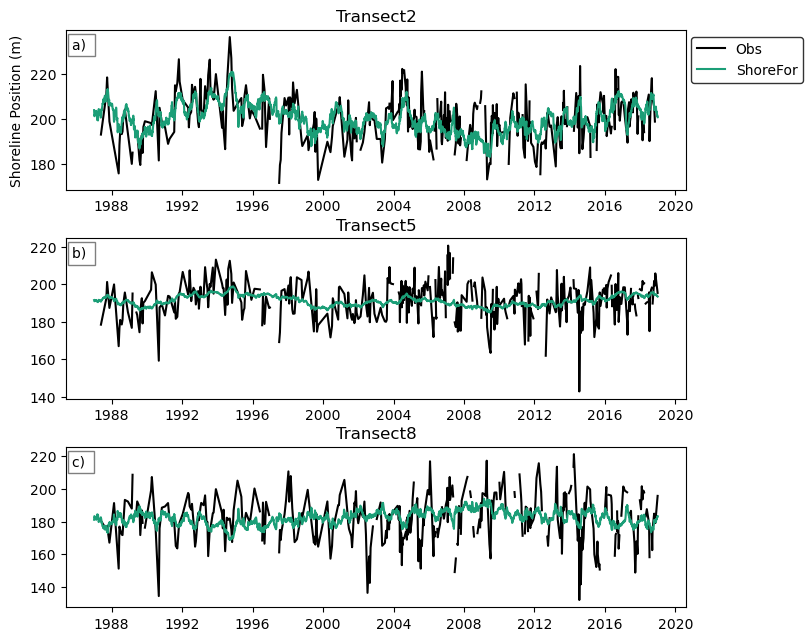

In [135]:
# Read obs and calibration shoreline data
df_obs = pd.read_csv(os.path.join(fp_input, fn_obs), index_col='Datetime')
df_obs.index = pd.to_datetime(df_obs.index)
df_obs.sort_index(inplace=True)

# Read model calibrations
dfs_cali = {}
for model in MODELS:
    if MODEL_TYPES[model]!= 'LLM': # LLM model was not calibrated for the time series
        df_cali = pd.read_csv(os.path.join(fp_sub.format(model), fn_cali), index_col='Datetime')
        df_cali.index = pd.to_datetime(df_cali.index)
            
        df_cali.sort_index(inplace=True)
        dfs_cali[model] = df_cali
    
# Plot timeseries comparison
fig = plot_ts(TRANSECTS, df_obs, dfs_cali)

## 2.1.2 Taylor Diagram for Model Ranking

Model performances will be ranked based on the Taylor Diagrams that compare the STD, RMSE and Correlation.\

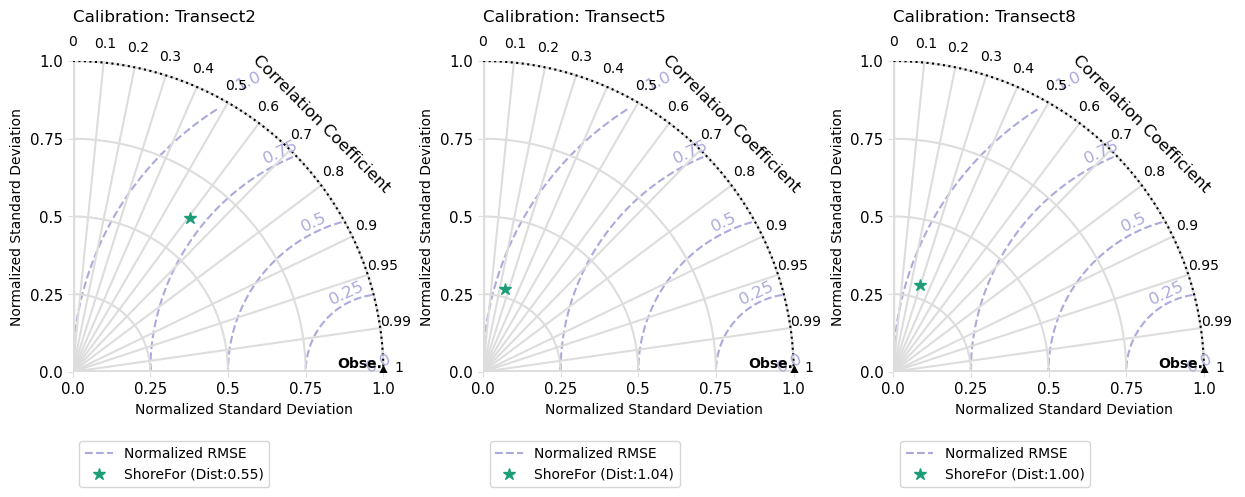

In [136]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, tran_id in enumerate(TRANSECTS):
    metrics = {}
    metrics["Observation"] = cal_metrics(df_obs[[tran_id]], df_obs[[tran_id]])
    metrics["Calibration"] = {}
    for model in MODELS:
        if MODEL_TYPES[model]!= 'LLM': # LLM model was not calibrated for the time series
            metrics["Calibration"][model] = cal_metrics(df_obs[[tran_id]], dfs_cali[model][[tran_id]])
    ax = axes[i]
    ax = plot_taylor(metrics, legend='Individual', ax=ax)
    ax.set_title('Calibration: {}'.format(tran_id), loc="left", y=1.1)


# 2.2 Prediction evaluation

## 2.2.1 Timeseries comparison

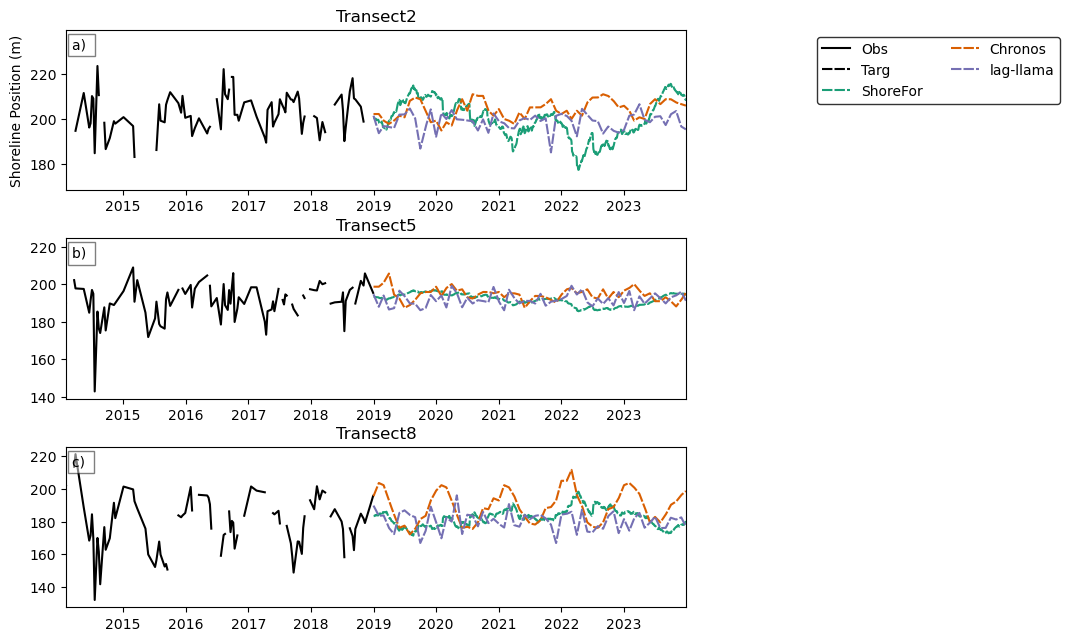

In [137]:
# Read obs and calibration shoreline data
df_targ = pd.read_csv(os.path.join(fp_input, fn_targ), index_col='Datetime')
df_targ.index = pd.to_datetime(df_targ.index)
df_targ.sort_index(inplace=True)

# Read model calibrations
dfs_pred = {}
for model in MODELS:
    df_pred = pd.read_csv(os.path.join(fp_sub.format(model), fn_pred), index_col='Datetime')
    df_pred.index = pd.to_datetime(df_pred.index)
    df_pred.sort_index(inplace=True)
    dfs_pred[model] = df_pred
    
# Plot timeseries comparison
fig = plot_ts(TRANSECTS, df_obs, df_targ=df_targ, dfs_pred=dfs_pred)

## 2.2.2 Taylor Diagram for model ranking (waiting for the disclosure of target data)

In [139]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 7))

# df_dist = pd.DataFrame(index=TRANSECTS, columns=MODELS) # Dataframe to save dist for model and transects

# for i, tran_id in enumerate(TRANSECTS):
#     metrics = {}
    
#     # Calculate metrics for the target
#     metrics["Target"] = cal_metrics(df_targ[[tran_id]], df_targ[[tran_id]])
#     metrics["Prediction"] = {}
#     for model in MODELS:
#         # Calculate metrics for predictions
#         metrics["Prediction"][model] = cal_metrics(df_targ[[tran_id]], dfs_pred[model][[tran_id]])
#         df_dist.loc[tran_id, model] = metrics["Prediction"][model][-1]

#     ax = axes[i]
#     if i != len(TRANSECTS)-1:
#         ax = plot_taylor(metrics, legend=None, ax=ax)
#     else:
#         ax = plot_taylor(metrics, legend='Average', aver_scores=df_dist.mean(0).to_dict(), ax=ax)
#     ax.set_title('Prediction: {}'.format(tran_id), loc="left", y=1.1)

# plt.subplots_adjust(wspace=0.2)
# plt.savefig('figures/TaylorDiagram.jpg', dpi=300, bbox_inches='tight')   